In [136]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold,KFold,GridSearchCV,GroupKFold,train_test_split
from rfpimp import *
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
pd.set_option('display.max_rows',200)

In [137]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_sub = pd.read_csv('sample_submission.csv')

In [138]:
df_train['Loan_Amount_Requested_New'] = df_train['Loan_Amount_Requested']
df_test['Loan_Amount_Requested_New']= df_test['Loan_Amount_Requested']

In [139]:
df_train['Loan_Amount_Requested'] = df_train['Loan_Amount_Requested'].apply(lambda x: eval(''.join(x.split(','))))
df_test['Loan_Amount_Requested'] = df_test['Loan_Amount_Requested'].apply(lambda x: eval(''.join(x.split(','))))

In [140]:
df_train.columns

Index(['Loan_ID', 'Loan_Amount_Requested', 'Length_Employed', 'Home_Owner',
       'Annual_Income', 'Income_Verified', 'Purpose_Of_Loan', 'Debt_To_Income',
       'Inquiries_Last_6Mo', 'Months_Since_Deliquency', 'Number_Open_Accounts',
       'Total_Accounts', 'Gender', 'Interest_Rate',
       'Loan_Amount_Requested_New'],
      dtype='object')

In [141]:
df_train['Closed'] = df_train['Total_Accounts'] - df_train['Number_Open_Accounts']
df_test['Closed'] = df_test['Total_Accounts'] - df_test['Number_Open_Accounts']

In [142]:
df_train.replace({'Length_Employed': {'1 year': '0-2 years',
                                     '2 years':'0-2 years',
                                     '3 years':'3-5 years',
                                     '4 years': '3-5 years',
                                      '5 years': '3-5 years',
                                     '6 years': '6-7 years',
                                     '7 years':'6-7 years',
                                     '8 years':'8-9 years',
                                     '9 years':'8-9 years',
                                     '< 1 year':'0-2 years'}},inplace=True)

In [143]:
length = {'10+ years': 10,
 '2 years': 2,
 '3 years': 3,
 '< 1 year': 0,
 '5 years': 5,
 '1 year': 1,
 '4 years': 4,
 '7 years': 7,
 '6 years': 6,
 '8 years': 8,
 '9 years': 9}
len_new =  {
    '3-5 years':1,
    '6-7 years':2,
    '8-9 years':3,
    '0-2 years':0,
    '10+ years':4
}
home = {'Mortgage': 0,
 'Rent': 1,
 'Own': 2,
 'Other': 3,
 'None': 4}
income = {'VERIFIED - income': 0,
 'VERIFIED - income source': 1,
 'not verified':2}
purp = {'debt_consolidation': 0,
 'credit_card': 1,
 'home_improvement':2,
 'other': 3,
 'major_purchase': 4,
 'small_business': 5,
 'car': 6,
 'medical': 7,
 'moving': 8,
 'vacation': 9,
 'wedding': 10,
 'house': 11,
 'renewable_energy': 12,
 'educational': 13}
gender = {'Male': 0, 'Female': 1}
target_lgb = {
    1:0,
    2:1,
    3:2
}

lgb_target = {
    0:1,
    1:2,
    2:3
}

In [144]:
df_train['Home_Owner'].value_counts()

Mortgage    70345
Rent        56031
Own         12525
Other          49
None           10
Name: Home_Owner, dtype: int64

In [145]:
df_train['Length_Employed'] = df_train['Length_Employed'].map(len_new)
# df_train['Length_Employed'] = df_train['Length_Employed'].fillna(-99999)
df_train['Home_Owner'] = df_train['Home_Owner'].map(home)
df_train['Home_Owner'] = df_train['Home_Owner'].fillna(-99999)
df_train['Income_Verified'] = df_train['Income_Verified'].map(income)
df_train['Purpose_Of_Loan'] = df_train['Purpose_Of_Loan'].map(purp)
df_train['Gender'] = df_train['Gender'].map(gender)
df_train['Interest_Rate'] = df_train['Interest_Rate'].map(target_lgb)

In [146]:
df_test['Length_Employed'] = df_test['Length_Employed'].map(len_new)
df_test['Home_Owner'] = df_test['Home_Owner'].map(home)
df_test['Home_Owner'] = df_test['Home_Owner'].fillna(-99999)
df_test['Income_Verified'] = df_test['Income_Verified'].map(income)
df_test['Purpose_Of_Loan'] = df_test['Purpose_Of_Loan'].map(purp)
df_test['Gender'] = df_test['Gender'].map(gender)
# df_test['Interest_Rate'] = df_test['Interest_Rate'].map(target_lgb)

In [147]:
df_train.drop('Loan_ID',axis=1,inplace=True)
df_test.drop('Loan_ID',axis=1,inplace=True)

In [148]:
df_train['Purpose_Of_Loan'].value_counts()

0     97101
1     36684
2      9269
3      8346
4      3435
5      2392
6      1885
7      1541
8       974
9       837
10      828
11      773
12      123
13      121
Name: Purpose_Of_Loan, dtype: int64

In [149]:
df_train.isnull().sum()

Loan_Amount_Requested            0
Length_Employed               7371
Home_Owner                       0
Annual_Income                25102
Income_Verified                  0
Purpose_Of_Loan                  0
Debt_To_Income                   0
Inquiries_Last_6Mo               0
Months_Since_Deliquency      88379
Number_Open_Accounts             0
Total_Accounts                   0
Gender                           0
Interest_Rate                    0
Loan_Amount_Requested_New        0
Closed                           0
dtype: int64

In [150]:
df_train = pd.get_dummies(data=df_train,columns=['Home_Owner','Purpose_Of_Loan','Income_Verified'])
df_test = pd.get_dummies(data=df_test,columns=['Home_Owner','Purpose_Of_Loan','Income_Verified'])

In [151]:
y_train

149378    1
155282    2
60521     0
120439    0
133084    1
         ..
1245      1
47077     1
120287    2
150664    1
25212     0
Name: Interest_Rate, Length: 123231, dtype: int64

In [152]:
# df_train.drop('Feat_1',axis=1,inplace=True)

In [153]:
X_train,X_valid,y_train,y_valid = train_test_split(df_train,df_train['Interest_Rate'],stratify=df_train['Interest_Rate'],random_state=22)

In [154]:
cumulative_sum = X_train.groupby('Loan_Amount_Requested_New')["Interest_Rate"].cumsum() - X_train["Interest_Rate"]
cumulative_count = X_train.groupby('Loan_Amount_Requested_New').cumcount()
X_train['Loan_Amount_Requested_New' + "_mean_target"] = cumulative_sum/cumulative_count

/home/arya/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [155]:
vals = X_train.groupby('Loan_Amount_Requested_New').agg({'Interest_Rate':['mean']})
vals.columns = [x[0] for x in vals.columns]
vals.rename(columns={'Interest_Rate':'Loan_Amount_Requested_New_mean_target'},inplace=True)

In [127]:
# X_train['cumulative_only'] =X_train.groupby(['Loan_Amount_Requested_New'])['Interest_Rate'].apply(lambda x: x.cumsum())


In [128]:
# vals = X_train.groupby('Loan_Amount_Requested_New').agg({'cumulative_only':['mean']})
# vals.columns = [x[0] for x in vals.columns]
# vals.rename(columns={'cumulative_only':'Loan_Amount_Requested_New_mean_target'},inplace=True)

In [129]:
vals

,Loan_Amount_Requested_New_mean_target
Loan_Amount_Requested_New,
"1,000",1.257143
"1,025",1.000000
"1,050",1.500000
"1,075",1.000000
"1,100",0.833333
...,...
"9,900",0.956522
"9,925",1.483871
"9,950",1.231707


In [156]:
X_valid = pd.merge(X_valid,vals,on='Loan_Amount_Requested_New',how='left')
df_test = pd.merge(df_test,vals,on='Loan_Amount_Requested_New',how='left')
# df_test.rename(columns={'cumulative_only':'Loan_Amount_Requested_New_mean_target'},inplace=True)
# X_valid.rename(columns={'cumulative_only':'Loan_Amount_Requested_New_mean_target'},inplace=True)
X_valid.drop(['Loan_Amount_Requested_New'],axis=1,inplace=True)
X_train.drop(['Loan_Amount_Requested_New'],axis=1,inplace=True)
df_test.drop(['Loan_Amount_Requested_New'],axis=1,inplace=True)

/home/arya/.local/lib/python3.6/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [2674]:
df_test.isnull().sum()

Loan_Amount_Requested                        0
Length_Employed                          74128
Annual_Income                            16898
Debt_To_Income                               0
Inquiries_Last_6Mo                           0
Months_Since_Deliquency                  58859
Number_Open_Accounts                         0
Total_Accounts                               0
Gender                                       0
Closed                                       0
Home_Owner_-99999.0                          0
Home_Owner_0.0                               0
Home_Owner_1.0                               0
Home_Owner_2.0                               0
Home_Owner_3.0                               0
Home_Owner_4.0                               0
Purpose_Of_Loan_0                            0
Purpose_Of_Loan_1                            0
Purpose_Of_Loan_2                            0
Purpose_Of_Loan_3                            0
Purpose_Of_Loan_4                            0
Purpose_Of_Lo

In [131]:
gkf = list(StratifiedKFold(n_splits=5,shuffle=True,random_state=22).split(X_train,y_train))

In [2555]:
#Best Model
m   = lgb.LGBMClassifier(random_state=22,n_jobs=-1,max_depth=-1,min_data_in_leaf=15,num_leaves=60,
                         bagging_fraction=0.05,colsample_bytree=1.lambda_l1=4.9,lambda_l2=5)

SyntaxError: invalid syntax (<ipython-input-2555-10c845fb3524>, line 3)

In [2556]:
params ={
'lambda_l1':[x/100 for x in range(480,500,2)],
'lambda_l2':[x/100 for x in range(490,510,2)],
}
gsearch1 = GridSearchCV(estimator=m,param_grid=params,n_jobs=-1,iid=False,cv=gkf,scoring='f1_weighted',verbose=2)
gsearch1.fit(X_train,y_train)

TypeError: estimator should be an estimator implementing 'fit' method,                          Importance
Feature                            
Loan_Amount_Requested        0.0594
Inquiries_Last_6Mo           0.0314
Months_Since_Deliquency      0.0200
Income_Verified_2            0.0170
Annual_Income                0.0164
Purpose_Of_Loan_1            0.0162
Debt_To_Income               0.0154
Closed                       0.0112
Home_Owner_0.0               0.0036
Purpose_Of_Loan_3            0.0032
Purpose_Of_Loan_0            0.0024
Home_Owner_1.0               0.0022
Purpose_Of_Loan_6            0.0020
Purpose_Of_Loan_7            0.0018
Purpose_Of_Loan_5            0.0012
Purpose_Of_Loan_2            0.0008
Purpose_Of_Loan_9            0.0008
Income_Verified_0            0.0006
Purpose_Of_Loan_11           0.0004
Length_Employed              0.0004
Purpose_Of_Loan_8            0.0000
Home_Owner_-99999.0          0.0000
Gender                      -0.0002
Purpose_Of_Loan_13          -0.0004
Income_Verified_1           -0.0008
Purpose_Of_Loan_4           -0.0016
Number_Open_Accounts        -0.0022
Total_Accounts              -0.0034 was passed

In [2557]:
 'min_child_weight':[1,2,3],
    'max_depth':[1,2,3]
         'colsample_bytree':[x/10 for x in range(0,10,1)],
    'subsample':[x/10 for x in range(0,10,1)]
'scale_pos_weight':[x/10 for x in range(5,21)]
      'gamma':[x/10 for x in range(0,5,1)]
'num_leaves':range(10,20,1),
'min_data_in_leaf':range(40,60,1),
'lambda_l1':[x/100 for x in range(0,20,1)],
'lambda_l2':[x/100 for x in range(0,20,1)],
'colsample_bytree':[x/10 for x in range(0,11,1)]
'bagging_fraction':[x/10 for x in range(0,100,5)]
       'reg_alpha':[x/100 for x in range(0,10,1)],
'reg_lambda':[x/100 for x in range(0,10,1)],

SyntaxError: invalid syntax (<ipython-input-2557-a150af05a4fe>, line 1)

In [2360]:
gsearch1.best_params_,gsearch1.best_score_

AttributeError: 'GridSearchCV' object has no attribute 'best_params_'

In [ ]:
splits = 5
folds = StratifiedKFold(n_splits=splits, shuffle=True, random_state=22)
predictions = np.zeros((len(X_valid), 3))
oof_preds = np.zeros((len(df_test), 3))
feature_importance_df = pd.DataFrame()
final_preds = []
random_state = [77,89,22,1007,1997,1890,2000,2020,8989,786,787,1999992,2021,7654]
for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train.values, y_train.values)):
        print("Fold {}".format(fold_))
        X_trn,y_trn = X_train[k].iloc[trn_idx],y_train.iloc[trn_idx]
        X_val,y_val = X_train[k].iloc[val_idx],y_train.iloc[val_idx]
        #Best Mode
        clf  = lgb.LGBMClassifier(random_state=22,n_jobs=-1,n_estimators=4000,learning_rate=0.05)
        clf.fit(X_trn, y_trn, eval_metric="multi_logloss", eval_set=[(X_val,y_val)], verbose=True,early_stopping_rounds=100)
        final_preds.append(f1_score(y_pred=[np.argmax(x) for x in clf.predict_proba(X_val)],y_true=y_val,average='weighted'))
        predictions += clf.predict_proba(X_valid[k])
        oof_preds += clf.predict_proba(df_test[k])
#         counter = counter + 1
oof_preds = oof_preds/splits
print(sum(final_preds)/splits)

Fold 0
[1]	valid_0's multi_logloss: 1.04963
Training until validation scores don't improve for 100 rounds
[2]	valid_0's multi_logloss: 1.0436
[3]	valid_0's multi_logloss: 1.038
[4]	valid_0's multi_logloss: 1.03281
[5]	valid_0's multi_logloss: 1.02796
[6]	valid_0's multi_logloss: 1.02346
[7]	valid_0's multi_logloss: 1.01922
[8]	valid_0's multi_logloss: 1.01524
[9]	valid_0's multi_logloss: 1.01145
[10]	valid_0's multi_logloss: 1.00799
[11]	valid_0's multi_logloss: 1.00467
[12]	valid_0's multi_logloss: 1.00154
[13]	valid_0's multi_logloss: 0.998587
[14]	valid_0's multi_logloss: 0.995797
[15]	valid_0's multi_logloss: 0.993119
[16]	valid_0's multi_logloss: 0.990619
[17]	valid_0's multi_logloss: 0.988252
[18]	valid_0's multi_logloss: 0.985959
[19]	valid_0's multi_logloss: 0.983746
[20]	valid_0's multi_logloss: 0.981629
[21]	valid_0's multi_logloss: 0.979753
[22]	valid_0's multi_logloss: 0.977814
[23]	valid_0's multi_logloss: 0.975998
[24]	valid_0's multi_logloss: 0.974301
[25]	valid_0's mult

[208]	valid_0's multi_logloss: 0.918707
[209]	valid_0's multi_logloss: 0.918662
[210]	valid_0's multi_logloss: 0.918654
[211]	valid_0's multi_logloss: 0.918616
[212]	valid_0's multi_logloss: 0.918612
[213]	valid_0's multi_logloss: 0.918589
[214]	valid_0's multi_logloss: 0.918554
[215]	valid_0's multi_logloss: 0.918523
[216]	valid_0's multi_logloss: 0.918508
[217]	valid_0's multi_logloss: 0.918512
[218]	valid_0's multi_logloss: 0.918491
[219]	valid_0's multi_logloss: 0.918476
[220]	valid_0's multi_logloss: 0.918457
[221]	valid_0's multi_logloss: 0.918471
[222]	valid_0's multi_logloss: 0.918457
[223]	valid_0's multi_logloss: 0.918431
[224]	valid_0's multi_logloss: 0.918415
[225]	valid_0's multi_logloss: 0.918393
[226]	valid_0's multi_logloss: 0.918346
[227]	valid_0's multi_logloss: 0.918328
[228]	valid_0's multi_logloss: 0.918319
[229]	valid_0's multi_logloss: 0.918313
[230]	valid_0's multi_logloss: 0.918316
[231]	valid_0's multi_logloss: 0.918302
[232]	valid_0's multi_logloss: 0.9183
[2

[415]	valid_0's multi_logloss: 0.917799
[416]	valid_0's multi_logloss: 0.917803
[417]	valid_0's multi_logloss: 0.917825
[418]	valid_0's multi_logloss: 0.917826
[419]	valid_0's multi_logloss: 0.917824
[420]	valid_0's multi_logloss: 0.917835
[421]	valid_0's multi_logloss: 0.917847
[422]	valid_0's multi_logloss: 0.917832
[423]	valid_0's multi_logloss: 0.917835
[424]	valid_0's multi_logloss: 0.91784
[425]	valid_0's multi_logloss: 0.917835
[426]	valid_0's multi_logloss: 0.917821
[427]	valid_0's multi_logloss: 0.917827
[428]	valid_0's multi_logloss: 0.917831
[429]	valid_0's multi_logloss: 0.917822
[430]	valid_0's multi_logloss: 0.917823
[431]	valid_0's multi_logloss: 0.917818
[432]	valid_0's multi_logloss: 0.917831
[433]	valid_0's multi_logloss: 0.917833
[434]	valid_0's multi_logloss: 0.91784
[435]	valid_0's multi_logloss: 0.917845
[436]	valid_0's multi_logloss: 0.917864
[437]	valid_0's multi_logloss: 0.917873
[438]	valid_0's multi_logloss: 0.917874
[439]	valid_0's multi_logloss: 0.917874
[4

[171]	valid_0's multi_logloss: 0.91744
[172]	valid_0's multi_logloss: 0.917399
[173]	valid_0's multi_logloss: 0.91735
[174]	valid_0's multi_logloss: 0.917298
[175]	valid_0's multi_logloss: 0.91724
[176]	valid_0's multi_logloss: 0.917229
[177]	valid_0's multi_logloss: 0.917203
[178]	valid_0's multi_logloss: 0.917177
[179]	valid_0's multi_logloss: 0.917118
[180]	valid_0's multi_logloss: 0.917081
[181]	valid_0's multi_logloss: 0.91704
[182]	valid_0's multi_logloss: 0.917017
[183]	valid_0's multi_logloss: 0.916963
[184]	valid_0's multi_logloss: 0.916894
[185]	valid_0's multi_logloss: 0.916881
[186]	valid_0's multi_logloss: 0.916812
[187]	valid_0's multi_logloss: 0.916764
[188]	valid_0's multi_logloss: 0.916726
[189]	valid_0's multi_logloss: 0.916681
[190]	valid_0's multi_logloss: 0.916658
[191]	valid_0's multi_logloss: 0.916605
[192]	valid_0's multi_logloss: 0.916599
[193]	valid_0's multi_logloss: 0.916552
[194]	valid_0's multi_logloss: 0.916532
[195]	valid_0's multi_logloss: 0.916476
[196

[385]	valid_0's multi_logloss: 0.914809
[386]	valid_0's multi_logloss: 0.914817
[387]	valid_0's multi_logloss: 0.914808
[388]	valid_0's multi_logloss: 0.914815
[389]	valid_0's multi_logloss: 0.914831
[390]	valid_0's multi_logloss: 0.914824
[391]	valid_0's multi_logloss: 0.914817
[392]	valid_0's multi_logloss: 0.914812
[393]	valid_0's multi_logloss: 0.9148
[394]	valid_0's multi_logloss: 0.914803
[395]	valid_0's multi_logloss: 0.914806
[396]	valid_0's multi_logloss: 0.91481
[397]	valid_0's multi_logloss: 0.914832
[398]	valid_0's multi_logloss: 0.914842
[399]	valid_0's multi_logloss: 0.914843
[400]	valid_0's multi_logloss: 0.914847
[401]	valid_0's multi_logloss: 0.914832
[402]	valid_0's multi_logloss: 0.91482
[403]	valid_0's multi_logloss: 0.914826
[404]	valid_0's multi_logloss: 0.914831
[405]	valid_0's multi_logloss: 0.914845
[406]	valid_0's multi_logloss: 0.914856
[407]	valid_0's multi_logloss: 0.914855
[408]	valid_0's multi_logloss: 0.914815
[409]	valid_0's multi_logloss: 0.914818
[410

[123]	valid_0's multi_logloss: 0.921177
[124]	valid_0's multi_logloss: 0.921034
[125]	valid_0's multi_logloss: 0.920899
[126]	valid_0's multi_logloss: 0.92077
[127]	valid_0's multi_logloss: 0.920623
[128]	valid_0's multi_logloss: 0.920486
[129]	valid_0's multi_logloss: 0.920402
[130]	valid_0's multi_logloss: 0.920283
[131]	valid_0's multi_logloss: 0.920179
[132]	valid_0's multi_logloss: 0.92006
[133]	valid_0's multi_logloss: 0.919949
[134]	valid_0's multi_logloss: 0.91984
[135]	valid_0's multi_logloss: 0.919693
[136]	valid_0's multi_logloss: 0.919594
[137]	valid_0's multi_logloss: 0.919477
[138]	valid_0's multi_logloss: 0.919381
[139]	valid_0's multi_logloss: 0.919284
[140]	valid_0's multi_logloss: 0.919184
[141]	valid_0's multi_logloss: 0.919074
[142]	valid_0's multi_logloss: 0.918974
[143]	valid_0's multi_logloss: 0.918905
[144]	valid_0's multi_logloss: 0.918792
[145]	valid_0's multi_logloss: 0.918708
[146]	valid_0's multi_logloss: 0.918626
[147]	valid_0's multi_logloss: 0.91854
[148

[336]	valid_0's multi_logloss: 0.914822
[337]	valid_0's multi_logloss: 0.914822
[338]	valid_0's multi_logloss: 0.914819
[339]	valid_0's multi_logloss: 0.914812
[340]	valid_0's multi_logloss: 0.914819
[341]	valid_0's multi_logloss: 0.914812
[342]	valid_0's multi_logloss: 0.914811
[343]	valid_0's multi_logloss: 0.914808
[344]	valid_0's multi_logloss: 0.9148
[345]	valid_0's multi_logloss: 0.914795
[346]	valid_0's multi_logloss: 0.914777
[347]	valid_0's multi_logloss: 0.914777
[348]	valid_0's multi_logloss: 0.914768
[349]	valid_0's multi_logloss: 0.914798
[350]	valid_0's multi_logloss: 0.914813
[351]	valid_0's multi_logloss: 0.914833
[352]	valid_0's multi_logloss: 0.914846
[353]	valid_0's multi_logloss: 0.914848
[354]	valid_0's multi_logloss: 0.914861
[355]	valid_0's multi_logloss: 0.914857
[356]	valid_0's multi_logloss: 0.91484
[357]	valid_0's multi_logloss: 0.914833
[358]	valid_0's multi_logloss: 0.914829
[359]	valid_0's multi_logloss: 0.914834
[360]	valid_0's multi_logloss: 0.914832
[36

[93]	valid_0's multi_logloss: 0.921892
[94]	valid_0's multi_logloss: 0.92166
[95]	valid_0's multi_logloss: 0.921418
[96]	valid_0's multi_logloss: 0.921175
[97]	valid_0's multi_logloss: 0.920917
[98]	valid_0's multi_logloss: 0.920664
[99]	valid_0's multi_logloss: 0.920463
[100]	valid_0's multi_logloss: 0.920259
[101]	valid_0's multi_logloss: 0.920058
[102]	valid_0's multi_logloss: 0.91988
[103]	valid_0's multi_logloss: 0.919664
[104]	valid_0's multi_logloss: 0.91942
[105]	valid_0's multi_logloss: 0.919242
[106]	valid_0's multi_logloss: 0.919081
[107]	valid_0's multi_logloss: 0.918873
[108]	valid_0's multi_logloss: 0.918634
[109]	valid_0's multi_logloss: 0.918452
[110]	valid_0's multi_logloss: 0.918268
[111]	valid_0's multi_logloss: 0.918086
[112]	valid_0's multi_logloss: 0.917925
[113]	valid_0's multi_logloss: 0.917773
[114]	valid_0's multi_logloss: 0.917641
[115]	valid_0's multi_logloss: 0.917481
[116]	valid_0's multi_logloss: 0.917312
[117]	valid_0's multi_logloss: 0.917128
[118]	vali

[301]	valid_0's multi_logloss: 0.909665
[302]	valid_0's multi_logloss: 0.909673
[303]	valid_0's multi_logloss: 0.909648
[304]	valid_0's multi_logloss: 0.909646
[305]	valid_0's multi_logloss: 0.909645
[306]	valid_0's multi_logloss: 0.909644
[307]	valid_0's multi_logloss: 0.909633
[308]	valid_0's multi_logloss: 0.909635
[309]	valid_0's multi_logloss: 0.909639
[310]	valid_0's multi_logloss: 0.909638
[311]	valid_0's multi_logloss: 0.909656
[312]	valid_0's multi_logloss: 0.909659
[313]	valid_0's multi_logloss: 0.909652
[314]	valid_0's multi_logloss: 0.909652
[315]	valid_0's multi_logloss: 0.909656
[316]	valid_0's multi_logloss: 0.909631
[317]	valid_0's multi_logloss: 0.909635
[318]	valid_0's multi_logloss: 0.90963
[319]	valid_0's multi_logloss: 0.909603
[320]	valid_0's multi_logloss: 0.909616
[321]	valid_0's multi_logloss: 0.909619
[322]	valid_0's multi_logloss: 0.909624
[323]	valid_0's multi_logloss: 0.909628
[324]	valid_0's multi_logloss: 0.90962
[325]	valid_0's multi_logloss: 0.909622
[3

In [159]:
print(f1_score(y_pred=[np.argmax(x) for x in predictions],y_true=y_valid,average='weighted'))

0.5347829643993863


In [2651]:
m = importances(clf,X_valid[k],y_valid)
m

,Importance
Feature,
Inquiries_Last_6Mo,0.0456
Loan_Amount_Requested_New_mean_target,0.0356
Months_Since_Deliquency,0.0258
Loan_Amount_Requested,0.0222
Debt_To_Income,0.0192
Closed,0.0184
Annual_Income,0.0140
Purpose_Of_Loan_1,0.0122
Income_Verified_2,0.0104


In [1447]:
m = lgb.LGBMClassifier(random_state=22,n_jobs=-1)
m.fit(X_train,y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=22, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [134]:
df_sub['Interest_Rate'] = [np.argmax(x) for x in oof_preds]
df_sub['Interest_Rate'] = df_sub['Interest_Rate'].map(lgb_target)

In [135]:
df_sub.to_csv('CheckingLoan.csv',index=False)

In [103]:
df_train['Interest_Rate'].value_counts(normalize=True)

1    0.429557
2    0.364697
0    0.205746
Name: Interest_Rate, dtype: float64

In [74]:
df_sub['Interest_Rate'].value_counts(normalize=True)

2    0.643659
3    0.260122
1    0.096220
Name: Interest_Rate, dtype: float64

In [ ]:
def lgb_f1_score(y_hat, data):
    y_true = data.get_label()
    y_hat = np.round(y_hat) # scikits f1 doesn't like probabilities
    return 'f1', f1_score(y_true, y_hat), True

In [3]:
df_train.shape

(164309, 14)

In [4]:
df_test.shape

(109541, 13)

In [5]:
df_train.isnull().sum()

Loan_ID                        0
Loan_Amount_Requested          0
Length_Employed             7371
Home_Owner                 25349
Annual_Income              25102
Income_Verified                0
Purpose_Of_Loan                0
Debt_To_Income                 0
Inquiries_Last_6Mo             0
Months_Since_Deliquency    88379
Number_Open_Accounts           0
Total_Accounts                 0
Gender                         0
Interest_Rate                  0
dtype: int64

In [6]:
df_test.isnull().sum()

Loan_ID                        0
Loan_Amount_Requested          0
Length_Employed             4936
Home_Owner                 16711
Annual_Income              16898
Income_Verified                0
Purpose_Of_Loan                0
Debt_To_Income                 0
Inquiries_Last_6Mo             0
Months_Since_Deliquency    58859
Number_Open_Accounts           0
Total_Accounts                 0
Gender                         0
dtype: int64

In [7]:
df_train['Length_Employed'].value_counts(normalize=True)

10+ years    0.337171
2 years      0.093158
3 years      0.082670
< 1 year     0.081593
5 years      0.068906
1 year       0.066408
4 years      0.062343
7 years      0.059310
6 years      0.057946
8 years      0.050447
9 years      0.040048
Name: Length_Employed, dtype: float64

In [8]:
df_test['Length_Employed'].value_counts(normalize=True)

10+ years    0.338540
2 years      0.093686
3 years      0.081296
< 1 year     0.079614
5 years      0.069098
1 year       0.066096
4 years      0.063181
6 years      0.059815
7 years      0.058659
8 years      0.049692
9 years      0.040323
Name: Length_Employed, dtype: float64

In [9]:
df_train['Home_Owner'].value_counts(normalize=True)

Mortgage    0.506225
Rent        0.403217
Own         0.090134
Other       0.000353
None        0.000072
Name: Home_Owner, dtype: float64

In [10]:
df_test['Home_Owner'].value_counts(normalize=True)

Mortgage    0.505494
Rent        0.404083
Own         0.089992
Other       0.000323
None        0.000108
Name: Home_Owner, dtype: float64

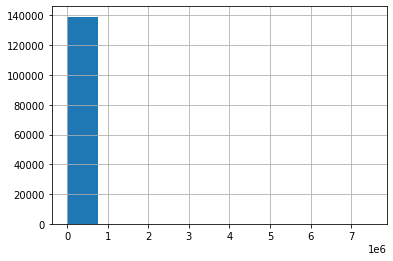

In [11]:
df_train['Annual_Income'].hist(bins=10)

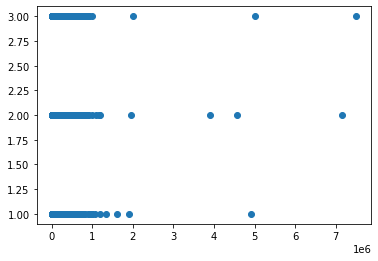

In [13]:
plt.scatter(df_train['Annual_Income'].values,df_train['Interest_Rate'].values)

In [14]:
df_test['Annual_Income'].max()

7446395.0

In [15]:
df_test['Annual_Income'].min()

3000.0

In [16]:
df_train['Interest_Rate'].value_counts(normalize=True)

2    0.429557
3    0.364697
1    0.205746
Name: Interest_Rate, dtype: float64

In [17]:
df_train.dtypes

Loan_ID                      int64
Loan_Amount_Requested       object
Length_Employed             object
Home_Owner                  object
Annual_Income              float64
Income_Verified             object
Purpose_Of_Loan             object
Debt_To_Income             float64
Inquiries_Last_6Mo           int64
Months_Since_Deliquency    float64
Number_Open_Accounts         int64
Total_Accounts               int64
Gender                      object
Interest_Rate                int64
dtype: object

In [18]:
df_train['Months_Since_Deliquency'].value_counts()

9.0      1518
10.0     1510
14.0     1487
12.0     1484
8.0      1474
         ... 
103.0       1
121.0       1
148.0       1
170.0       1
130.0       1
Name: Months_Since_Deliquency, Length: 122, dtype: int64

In [19]:
df_train

,Loan_ID,Loan_Amount_Requested,Length_Employed,Home_Owner,Annual_Income,Income_Verified,Purpose_Of_Loan,Debt_To_Income,Inquiries_Last_6Mo,Months_Since_Deliquency,Number_Open_Accounts,Total_Accounts,Gender,Interest_Rate
0,10000001,"7,000",< 1 year,Rent,68000.0,not verified,car,18.37,0,NaN,9,14,Female,1
1,10000002,"30,000",4 years,Mortgage,NaN,VERIFIED - income,debt_consolidation,14.93,0,17.0,12,24,Female,3
2,10000003,"24,725",7 years,Mortgage,75566.4,VERIFIED - income source,debt_consolidation,15.88,0,NaN,12,16,Male,3
3,10000004,"16,000",< 1 year,NaN,56160.0,VERIFIED - income source,debt_consolidation,14.34,3,NaN,16,22,Male,3
4,10000005,"17,000",8 years,Own,96000.0,VERIFIED - income source,debt_consolidation,22.17,1,NaN,19,30,Female,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
164304,10164305,"20,725",10+ years,Rent,NaN,VERIFIED - income source,credit_card,13.56,0,NaN,13,16,Male,2
164305,10164306,"6,000",8 years,Own,NaN,VERIFIED - income source,small_business,9.12,0,36.0,13,30,Male,2
164306,10164307,"20,250",10+ years,Mortgage,NaN,VERIFIED - income,credit_card,18.17,1,NaN,17,30,Male,1
164307,10164308,"10,000",4 years,Rent,NaN,not verified,major_purchase,18.75,1,48.0,16,62,Female,3


In [32]:
df_train['Income_Verified'].value_counts(normalize=True).to_dict()

{'VERIFIED - income': 0.3616417846861706,
 'VERIFIED - income source': 0.32265426726472685,
 'not verified': 0.3157039480491026}

In [37]:
purp = {'VERIFIED - income': 0,
 'VERIFIED - income source': 1,
 'not verified':2}

In [40]:
df_train['Income_Verified'] = df_train['Income_Verified'].map(purp)

In [52]:
df_train[df_train['Length_Employed'] == '< 1 year']['Interest_Rate'].value_counts()

2    5613
3    4327
1    2865
Name: Interest_Rate, dtype: int64

In [ ]:
#Feats Closed Acc
#Debt

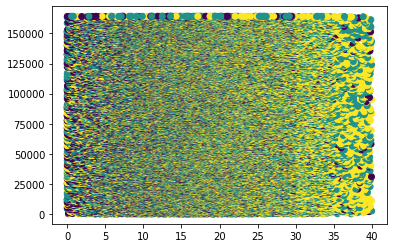

In [49]:
plt.scatter(x=df_train['Debt_To_Income'].values,y=range(len(df_train)),c=df_train['Interest_Rate'])

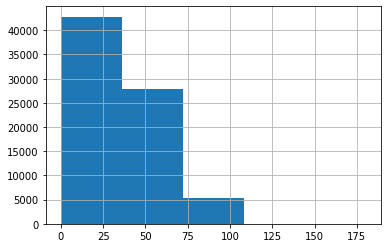

In [28]:
df_train['Months_Since_Deliquency'].hist(bins=5)

In [2025]:
X_train['Dum_1'] = np.random.randint(0,1)
X_train['Dum_2'] = np.random.randint(0,100)
X_train['Dum_3'] = np.random.randint(0,100000)

In [2026]:
from collections import defaultdict
from tqdm import tqdm
def _create_shadow(x):
    """
    Take all X variables, creating copies and randomly shuffling them
    :param x: the dataframe to create shadow features on
    :return: dataframe 2x width and the names of the shadows for removing later
    """
    x_shadow = x.copy()
    for c in x_shadow.columns:
        np.random.shuffle(x_shadow[c].values) # shuffle the values of each feature to all the features
    # rename the shadow
    shadow_names = ["shadow_feature_" + i for i in x.columns]
    x_shadow.columns = shadow_names
    # Combine to make one new dataframe
    x_new = pd.concat([x, x_shadow], axis=1)
    return x_new, shadow_names


# Set up the parameters for running the model in XGBoost
# params = {
#     'n_estimators':100,
#     'random_state':22,
#     'n_jobs':-1
# }
df = pd.DataFrame() # initial empty dataframe

n_iterations = 5
d = defaultdict(list)
for i in tqdm(range(1, n_iterations + 1)):
    # Create the shadow variables and run the model to obtain importances
# results = pd.DataFrame(columns='training_score', 'test_score')
    cv = StratifiedKFold(n_splits=5)
    score_avg = []
    for (train, test), i in zip(cv.split(X_train, y_train), range(5)):
        new_x, shadow_names = _create_shadow(X_train.iloc[train])
        valid_x,shadow_names = _create_shadow(X_train.iloc[test])
        model = lgb.LGBMClassifier(n_jobs=-1)
        model.fit(new_x,y_train.iloc[train])
        imp = importances(model,valid_x,y_train.iloc[test],n_samples=-1)
        imp.reset_index(inplace=True)
        if len(d) == 0:
            for i,j in imp.values:
                d[i].append(j)
        else:
            for i,j in imp.values:
                d[i].append(j)

100%|██████████| 5/5 [06:25<00:00, 77.14s/it]


In [2027]:
df_feature_importance = pd.DataFrame(data=d)
d_t = defaultdict(list)
for i in df_feature_importance.columns:
    mean_val = df_feature_importance[i].mean() * 100
    d_t[i].append(mean_val)
df_features = pd.DataFrame(data=d_t).T
df_features.reset_index(inplace=True)
df_features.sort_values(by=[0],ascending=False)

,index,0
0,Loan_Amount_Requested,5.059766
1,Inquiries_Last_6Mo,3.455786
2,Months_Since_Deliquency,2.388523
4,Purpose_Of_Loan_1,1.771470
5,Annual_Income,1.655589
3,Debt_To_Income,1.560321
7,Income_Verified_2,1.467813
6,Closed,1.216252
8,Income_Verified_0,0.544505
9,Purpose_Of_Loan_3,0.345530


In [2028]:
rf = df_features.sort_values(by=[0],ascending=False)
rf.reset_index(inplace=True,drop=True)
rf

,index,0
0,Loan_Amount_Requested,5.059766
1,Inquiries_Last_6Mo,3.455786
2,Months_Since_Deliquency,2.388523
3,Purpose_Of_Loan_1,1.771470
4,Annual_Income,1.655589
5,Debt_To_Income,1.560321
6,Income_Verified_2,1.467813
7,Closed,1.216252
8,Income_Verified_0,0.544505
9,Purpose_Of_Loan_3,0.345530


In [2029]:
k = rf['index'][0:43].tolist()

In [160]:
k =['Loan_Amount_Requested',
 'Inquiries_Last_6Mo',
 'Months_Since_Deliquency',
 'Purpose_Of_Loan_1',
 'Annual_Income',
 'Debt_To_Income',
 'Income_Verified_2',
 'Closed',
 'Income_Verified_0',
 'Purpose_Of_Loan_3',
 'Purpose_Of_Loan_0',
 'Home_Owner_1.0',
 'Length_Employed',
 'Purpose_Of_Loan_5',
 'Total_Accounts',
 'Purpose_Of_Loan_8',
 'Purpose_Of_Loan_6',
 'Number_Open_Accounts',
 'Home_Owner_0.0',
 'Purpose_Of_Loan_4',
 'Purpose_Of_Loan_7',
 'Purpose_Of_Loan_9',
 'Purpose_Of_Loan_2',
 'Purpose_Of_Loan_13',
 'Income_Verified_1',
 'Gender',
 'Home_Owner_-99999.0',
 'Purpose_Of_Loan_11',
   'Loan_Amount_Requested_New_mean_target']

In [2616]:
rf.to_csv('Final_cols.csv')

In [105]:
cv = StratifiedKFold(n_splits=5,shuffle=True,random_state=22)
results = pd.DataFrame(columns=['training_score', 'test_score'])
score_avg = []
for (train, test), i in zip(cv.split(X_train, y_train), range(5)):
    m_lgb  = lgb.LGBMClassifier(random_state=22,n_jobs=-1)
    m_lgb.fit(X_train[k].iloc[train], y_train.iloc[train])
    score_avg.append(f1_score(y_pred=m_lgb.predict(X_train[k].iloc[test]),y_true=y_train.iloc[test],average='weighted'))
print(pd.DataFrame(data=score_avg))
print(sum(score_avg)/len(score_avg))

          0
0  0.527311
1  0.532359
2  0.527893
3  0.539360
4  0.529677
0.5313200469684716


In [106]:
print(f1_score(m_lgb.predict(X_valid[k]),y_valid,average='weighted'))

0.5527722950340497


In [2619]:
imp = importances(m_lgb,X_valid[k],y_valid)

In [2620]:
imp

,Importance
Feature,
Inquiries_Last_6Mo,0.0310
Months_Since_Deliquency,0.0264
Purpose_Of_Loan_1,0.0262
Loan_Amount_Requested_New_mean_target,0.0188
Loan_Amount_Requested,0.0180
Debt_To_Income,0.0162
Closed,0.0138
Income_Verified_2,0.0104
Annual_Income,0.0094


In [2480]:
from sklearn import preprocessing


class CategoricalFeatures:
    def __init__(self,df,categorical_features,encoding_type,handle_na=False):
        """
        :param df:pandas df
        :param categorical_features: list of columns[ord1,ord2 ..]
        :param encoding_type: label,binary,ohe
        :param handle_na: True/False
        """

        self.df = df
        self.cat_feats = categorical_features
        self.encod_type = encoding_type
        self.handle_na = handle_na
        self.label_encoders = dict()
        self.binary_encoders = dict()
        self.ohe = None

        if self.handle_na:
            for c in self.cat_feats:
                self.df.loc[:, c] = self.df.loc[:, c].astype(str).fillna("-999999")
        self.output_df = self.df.copy(deep=True)

    def _label_encoding(self):
        for c in self.cat_feats:
            lbl = preprocessing.LabelEncoder()
            lbl.fit(self.df[c].values)
            self.output_df.loc[:,c] = lbl.transform(self.df[c].values)
            self.label_encoders[c] = lbl
        return self.output_df

    def _label_binarization(self):
        for c in self.cat_feats:
            lbl = preprocessing.LabelBinarizer()
            lbl.fit(self.df[c].values)
            val = lbl.transform(self.df[c].values)
            self.output_df = self.output_df.drop(c,axis=1)
            for j in range(val.shape[1]):
                new_col_name = c + f"__bin_{j}"
                self.output_df[new_col_name] = val[:, j]
            self.binary_encoders[c] = lbl
        return self.output_df

    def _one_hot(self):
        ohe = preprocessing.OneHotEncoder()
        ohe.fit(self.df[self.cat_feats].values)
        return ohe.transform(self.df[self.cat_feats].values)

    def fit_transform(self):
        if self.encod_type == "label":
            return self._label_encoding()
        elif self.encod_type == "binary":
            return self._label_binarization()
        elif self.encod_type == "ohe":
            return self._one_hot()
        else:
            raise Exception("Encoding type Error")

    def transform(self,dataframe):
        if self.handle_na:
            for c in self.cat_feats:
                dataframe.loc[:, c] = dataframe.loc[:,c].astype(str).fillna("-999999")

        if self.encod_type == "label":
            for c, lbl in self.label_encoders.items():
                dataframe.loc[:,c] = lbl.transform(dataframe[c].values)
            return dataframe

        elif self.encod_type == "binary":
            for c,lbl in self.binary_encoders.items():
                val = lbl.transform(dataframe[c].values)
                dataframe = dataframe.drop(c,axis=1)

                for j in range(val.shape[1]):
                    new_col_name = c + f"__bin_{j}"
                    dataframe[new_col_name] = val[:, j]
            return dataframe
        elif self.encod_type == "ohe":
            return self.ohe(dataframe[self.cat_feats].values)
        else:
            raise Exception("Encoding type not available")